In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Point, Polygon
from matplotlib import gridspec




/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# read in a shapefile to a geodataframe

In [3]:
croprot = gp.read_file('../llira_swb-modflow/parcel_rot.shp')
croprot.head()

,parcel_id,rotation,ag_acres,area,geometry
0,2954.0,potato/veg,36.026111,162609.153840,"POLYGON ((536974.855 404330.763, 536974.723 40..."
1,2955.0,potato/veg,34.691810,162787.235436,"POLYGON ((536570.861 404331.706, 536570.755 40..."
2,2956.0,potato/veg,37.582794,162375.668829,"POLYGON ((536567.412 403928.738, 536563.963 40..."
3,2957.0,potato/veg,38.694711,162140.079825,"POLYGON ((536970.162 403928.139, 536965.467 40..."
4,9102.0,cash_grain,28.687458,176009.103330,"POLYGON ((546291.482 371278.913, 545891.201 37..."


<AxesSubplot:>

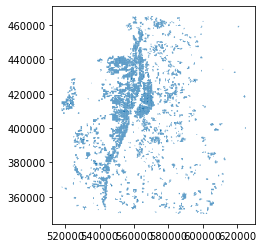

In [4]:
croprot.plot()

# a little aside on spatial joins

(400000.0, 405000.0)

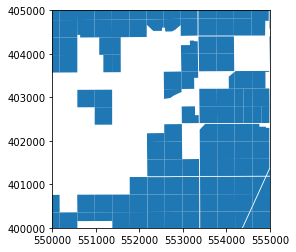

In [5]:
# let's zoom in on a small area to look at
croprot.plot()
plt.xlim([550000,555000])
plt.ylim([400000, 405000])


In [6]:
# we can cook up a polygon and yank out only the polygons within it


In [7]:
subset = Polygon([(550000,400000),
                  (550000,405000), 
                  (555000,405000),
                  (555000,400000),
                 (550000,400000)])
subgdf = gp.GeoDataFrame({'outline':['p0'],
                         'geometry':[subset]},
                        crs=croprot.crs)

<AxesSubplot:>

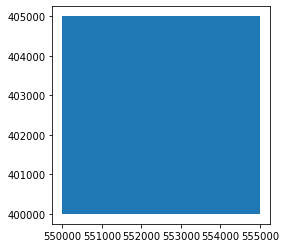

In [8]:
subgdf.plot()

In [9]:
croprot_sub = gp.overlay(croprot, subgdf)

In [10]:
# we need to cook up a dataframe real quick once
pt_df = gp.GeoDataFrame({'ptname':['pt0','pt1'],
                        'geometry':[Point(554000,403000),
                                   Point(552000,403000)]},
                       crs=croprot.crs)

In [11]:
pt_df

,ptname,geometry
0,pt0,POINT (554000.000 403000.000)
1,pt1,POINT (552000.000 403000.000)


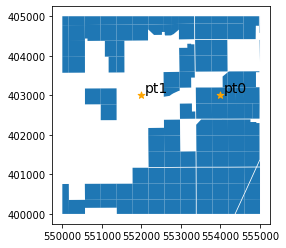

In [12]:
# we can pick a point at which we want attributes
ax = croprot_sub.plot()

pt_df.plot(marker='*', facecolor='orange', markersize=50, ax=ax)

# sadly, labeling points is BRUTAL
for x,y,label in zip(pt_df.geometry.x, pt_df.geometry.y, pt_df.ptname):
    ax.annotate(label, xy=(x,y), xytext=(3,3), size=14, textcoords = "offset points")


In [13]:
gp.sjoin(croprot_sub, pt_df, predicate='intersects')

,parcel_id,rotation,ag_acres,area,outline,geometry,index_right,ptname
86,2945085.0,potato/veg,33.802277,162663.574037,p0,"POLYGON ((553783.538 402795.082, 553780.166 40...",0,pt0


In [14]:
# Let's add a polygon
poly_df = gp.GeoDataFrame({'polname':['p0'],
                        'geometry':[Polygon([(554000,403000),
                                            (552000,403000),
                                            (553000,402000),
                                            (554000,402000),
                                            (554000,403000)])]},
                       crs=croprot.crs)


<AxesSubplot:>

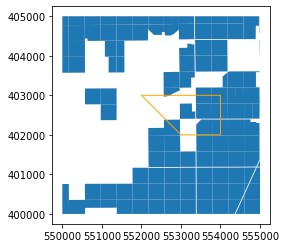

In [15]:
ax = croprot_sub.plot()

poly_df.plot(ax=ax, facecolor='none', edgecolor='orange')

In [16]:
# there are a few ways to spatially join. Let's check them out

Text(0.5, 1.0, 'instersects')

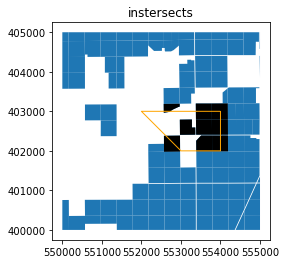

In [17]:
ax = croprot_sub.plot()
gp.sjoin(croprot_sub, poly_df, predicate='intersects').plot(ax=ax, facecolor='k')
poly_df.plot(ax=ax, facecolor='none', edgecolor='orange')
plt.title('instersects')

/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(0.5, 1.0, 'contains')

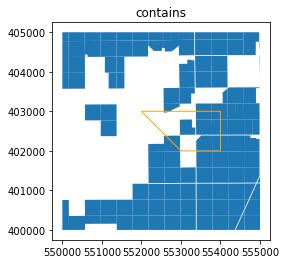

In [18]:
ax = croprot_sub.plot()
gp.sjoin(croprot_sub, poly_df, predicate='contains').plot(ax=ax, facecolor='k')
poly_df.plot(ax=ax, facecolor='none', edgecolor='orange')
plt.title('contains')

Text(0.5, 1.0, 'within')

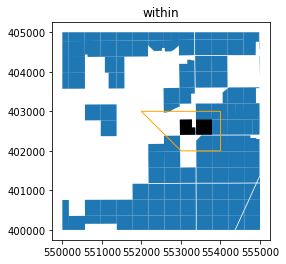

In [19]:
ax = croprot_sub.plot()
gp.sjoin(croprot_sub, poly_df, predicate='within').plot(ax=ax, facecolor='k')
poly_df.plot(ax=ax, facecolor='none', edgecolor='orange')
plt.title('within')

Text(0.5, 1.0, 'contains from the opposite direction')

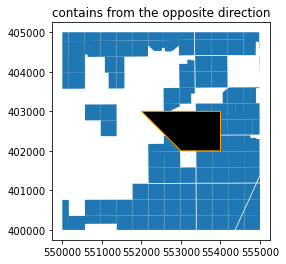

In [20]:
ax = croprot_sub.plot()
gp.sjoin(poly_df, croprot_sub, predicate='contains').plot(ax=ax, facecolor='k')
poly_df.plot(ax=ax, facecolor='none', edgecolor='orange')
plt.title('contains from the opposite direction')

# now back to the main goal

<AxesSubplot:>

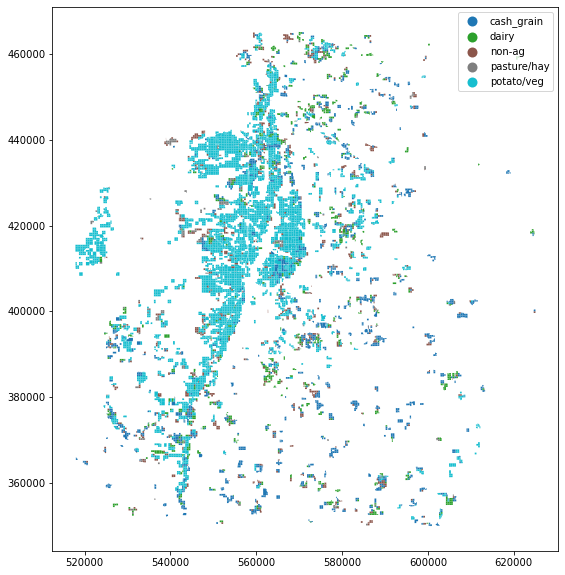

In [21]:
croprot.plot(column='rotation', legend=True, figsize=(10,10))


In [22]:
# we will need bounding boxes for the inset models
pfl_bbox = gp.read_file('../plainfield-lakes-lgr/pst_setup/postproc/shps/pfl_lgr_parent_bbox.shp')
plsnt_bbox = gp.read_file('../pleasant-lake-lgr/pst_setup/postproc/shps/plsnt_lgr_parent_bbox.shp')


In [23]:
# we will need to trim this to the model boundary
regional_bbox = gp.read_file('../gis/centralsands/model_domain_poly.shp').to_crs(pfl_bbox.crs)
regional_bbox.crs

<Projected CRS: EPSG:3070>
Name: NAD83 / Wisconsin Transverse Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Wisconsin.
- bounds: (-92.89, 42.48, -86.25, 47.31)
Coordinate Operation:
- name: Wisconsin Transverse Mercator 83
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [24]:
# let's intersect the main coverage with just the two insets

In [25]:
gp.overlay(croprot,pfl_bbox, how='intersection')

/var/folders/gs/23hp3rd15qd6tyrfwt0r90qxz48f2r/T/ipykernel_86552/2917877822.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3071
Right CRS: EPSG:3070

  gp.overlay(croprot,pfl_bbox, how='intersection')


,parcel_id,rotation,ag_acres,area,desc,geometry
0,1921969.0,potato/veg,6.004352,26296.122324,model bounding box,"POLYGON ((558467.570 420512.759, 558471.348 42..."
1,1922017.0,potato/veg,19.569739,77601.656050,model bounding box,"POLYGON ((558479.744 419931.375, 558253.100 41..."
2,1922018.0,potato/veg,37.805178,162640.092015,model bounding box,"POLYGON ((558876.590 420328.761, 558883.185 41..."
3,1922053.0,potato/veg,26.908391,113637.746820,model bounding box,"POLYGON ((558218.934 419845.067, 558225.766 41..."
4,1922086.0,potato/veg,30.688909,142082.693487,model bounding box,"POLYGON ((558496.438 419134.078, 558496.572 41..."
...,...,...,...,...,...,...
1145,2956993.0,potato/veg,71.385071,301312.465019,model bounding box,"POLYGON ((578735.606 415762.700, 578800.000 41..."
1146,2957013.0,cash_grain,32.912743,147237.709842,model bounding box,"POLYGON ((577623.272 415704.781, 577624.166 41..."
1147,2957018.0,cash_grain,25.796474,139389.659751,model bounding box,"POLYGON ((577543.610 415154.120, 577544.029 41..."
1148,2957678.0,cash_grain,32.690360,155319.829748,model bounding box,"POLYGON ((576571.454 409836.368, 576569.646 41..."


In [26]:
# 'doh! let's reproject

In [27]:
croprot = croprot.to_crs(pfl_bbox.crs)

In [28]:
# WTH? NoneType???
croprot

,parcel_id,rotation,ag_acres,area,geometry
0,2954.0,potato/veg,36.026111,162609.153840,"POLYGON ((536974.670 404330.671, 536974.538 40..."
1,2955.0,potato/veg,34.691810,162787.235436,"POLYGON ((536570.676 404331.615, 536570.570 40..."
2,2956.0,potato/veg,37.582794,162375.668829,"POLYGON ((536567.228 403928.647, 536563.779 40..."
3,2957.0,potato/veg,38.694711,162140.079825,"POLYGON ((536969.977 403928.048, 536965.282 40..."
4,9102.0,cash_grain,28.687458,176009.103330,"POLYGON ((546291.321 371278.771, 545891.040 37..."
...,...,...,...,...,...
9231,2964392.0,potato/veg,38.249945,155250.372501,"POLYGON ((555009.728 398808.243, 555019.676 39..."
9232,2964393.0,potato/veg,39.806628,164357.574789,"POLYGON ((554626.538 398812.034, 554635.525 39..."
9233,2964394.0,potato/veg,36.470877,152963.101885,"POLYGON ((555019.676 398402.785, 555029.242 39..."
9234,3053384.0,potato/veg,37.360411,161711.118365,"POLYGON ((540273.042 434182.609, 540283.104 43..."


In [29]:
croprot = croprot.dropna()
croprot

,parcel_id,rotation,ag_acres,area,geometry
0,2954.0,potato/veg,36.026111,162609.153840,"POLYGON ((536974.670 404330.671, 536974.538 40..."
1,2955.0,potato/veg,34.691810,162787.235436,"POLYGON ((536570.676 404331.615, 536570.570 40..."
2,2956.0,potato/veg,37.582794,162375.668829,"POLYGON ((536567.228 403928.647, 536563.779 40..."
3,2957.0,potato/veg,38.694711,162140.079825,"POLYGON ((536969.977 403928.048, 536965.282 40..."
4,9102.0,cash_grain,28.687458,176009.103330,"POLYGON ((546291.321 371278.771, 545891.040 37..."
...,...,...,...,...,...
9230,2964391.0,potato/veg,35.803727,152858.558708,"POLYGON ((554823.288 399207.736, 555001.064 39..."
9231,2964392.0,potato/veg,38.249945,155250.372501,"POLYGON ((555009.728 398808.243, 555019.676 39..."
9232,2964393.0,potato/veg,39.806628,164357.574789,"POLYGON ((554626.538 398812.034, 554635.525 39..."
9233,2964394.0,potato/veg,36.470877,152963.101885,"POLYGON ((555019.676 398402.785, 555029.242 39..."


In [30]:
# try again
croprot = croprot.to_crs(pfl_bbox.crs)

In [31]:
croprot.crs

<Projected CRS: EPSG:3070>
Name: NAD83 / Wisconsin Transverse Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Wisconsin.
- bounds: (-92.89, 42.48, -86.25, 47.31)
Coordinate Operation:
- name: Wisconsin Transverse Mercator 83
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
pfl_LU = gp.overlay(croprot,pfl_bbox, how='intersection')

In [33]:
#sweet! no warning about crs

In [34]:
croprot = gp.overlay(croprot, regional_bbox, how='intersection')

<AxesSubplot:>

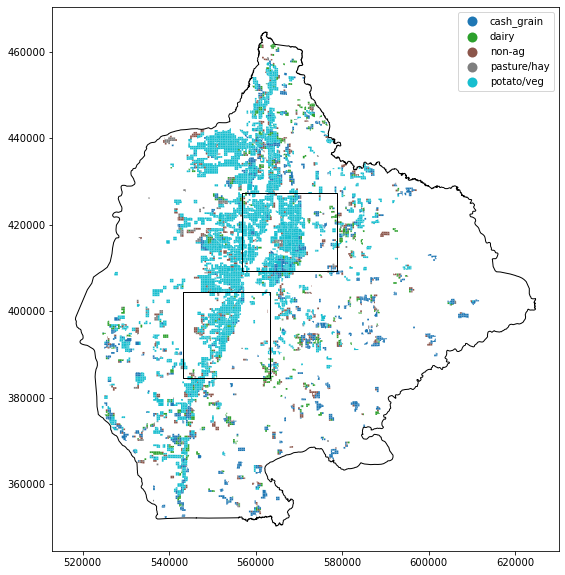

In [35]:
ax = croprot.plot(column='rotation', legend=True, figsize=(10,10))
pfl_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
plsnt_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
regional_bbox.plot(ax=ax, facecolor="none", edgecolor='black')

<AxesSubplot:>

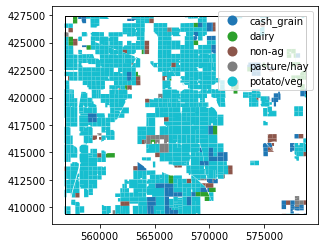

In [36]:
ax = pfl_LU.plot(column='rotation', legend=True)
pfl_bbox.plot(ax=ax, facecolor="none", edgecolor='black')

In [37]:
# let's bring in the lakes to plot as well
alllakes = gp.read_file('../gis/centralsands/all_lakes.shp')

In [38]:
# make sure in the correct CRS
assert alllakes.crs == pfl_bbox.crs

In [39]:
pfl_lakes = gp.overlay(alllakes, pfl_bbox, how='intersection')
plsnt_lakes = gp.overlay(alllakes, plsnt_bbox, how='intersection')


<AxesSubplot:>

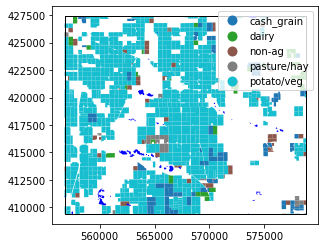

In [40]:
ax = pfl_LU.plot(column='rotation', legend=True)
pfl_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
pfl_lakes.plot(ax=ax, facecolor="blue")

In [41]:
plsnt_LU = gp.overlay(croprot,plsnt_bbox, how='intersection')

<AxesSubplot:>

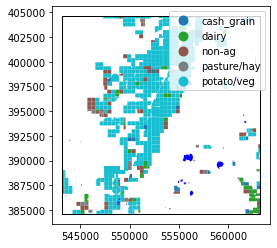

In [42]:
ax = plsnt_LU.plot(column='rotation', legend=True)
plsnt_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
plsnt_lakes.plot(ax=ax, facecolor="blue")

In [43]:
# let's get nutty with the legend 

In [44]:
plsnt_LU.rotation.unique()

array(['non-ag', 'dairy', 'potato/veg', 'pasture/hay', 'cash_grain'],
      dtype=object)

In [45]:
# grab some colors form the interwebs
# https://htmlcolorcodes.com/color-names/
rotcolors = {'non-ag':'Black',
             'cash_grain':'DarkGreen',
             'dairy': 'Orange',
             'potato/veg': 'SlateGrey',
             'pasture/hay': 'Gold'
            }
rotnames ={'non-ag':'Non Agriculture',
             'cash_grain':'Cash Grain',
             'dairy': 'Dairy',
             'potato/veg': 'Potato/Vegetable',
             'pasture/hay': 'Pasture/Hay'
            }

##### read in the non-ag landuse 

In [46]:
nonag_lu = gp.read_file('shapefiles/no_irrigation_LU/irr_parcel_reclass_20210212/irr_parcel_reclass_20210212.shp')
nonag_lu.crs

<Projected CRS: EPSG:3071>
Name: NAD83(HARN) / Wisconsin Transverse Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Wisconsin.
- bounds: (-92.89, 42.48, -86.25, 47.31)
Coordinate Operation:
- name: Wisconsin Transverse Mercator 83
- method: Transverse Mercator
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
nonag_lu = nonag_lu.to_crs(pfl_bbox.crs)
nonag_lu.crs

<Projected CRS: EPSG:3070>
Name: NAD83 / Wisconsin Transverse Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Wisconsin.
- bounds: (-92.89, 42.48, -86.25, 47.31)
Coordinate Operation:
- name: Wisconsin Transverse Mercator 83
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [48]:
# read in the code lookup for nonag
nonag_lookup = pd.read_csv('shapefiles/no_irrigation_LU/wiscland_xref.csv', index_col = 0)

In [49]:
nonag_lookup.head()


,label
dn label,
1000,URBAN/DEVELOPED
1100,"Developed, High Intensity"
1200,"Developed, Low Intensity"
2000,AGRICULTURE
2100,Crop Rotation


In [50]:
nonag_lookup.loc[2100]['label']

'Crop Rotation'

In [51]:
# we can do normal pandas things
nonag_lu.wl_lev2_cd = [nonag_lookup.loc[i,'label'] for i in nonag_lu.wl_lev2_cd]

In [52]:
nonag_lu.loc[nonag_lu.wl_lev2_cd == 'Crop Rotation', 'wl_lev2_cd'] = 'Nonirrigated Agriculture'

<AxesSubplot:>

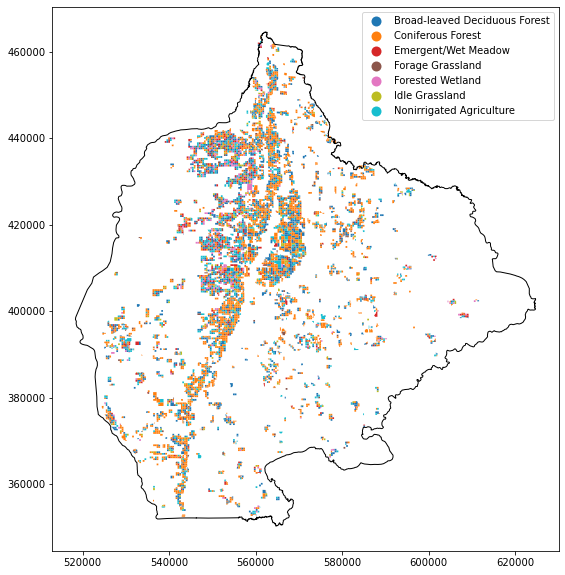

In [53]:
# and change "Crop Rotation" label to "Nonirrigated Agriculture"
ax = nonag_lu.plot(column = 'wl_lev2_cd', legend=True, figsize=(10,10))
regional_bbox.plot(ax=ax, edgecolor="k", facecolor='none' )

In [54]:
from Figures import ReportFigures

rf = ReportFigures()
rf.set_style()
default_aspect = 6 / 8.0 # h/w
tall_aspect = 7 / 8.0
singlecolumn_width = 21/6.0
doublecolumn_width = 42/6.0

singlecolumn_size = (singlecolumn_width, singlecolumn_width * default_aspect)
singlecolumn_sizeT = (singlecolumn_width, singlecolumn_width * tall_aspect)
doublecolumn_size = (doublecolumn_width, doublecolumn_width * default_aspect)
doublecolumn_sizeT = (doublecolumn_width, doublecolumn_width * tall_aspect)

/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/mpl_toolkits/basemap/__init__.py:33: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _matplotlib_version = LooseVersion(_matplotlib_version)
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/mpl_toolkits/basemap/__init__.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _mpl_required_version = LooseVersion('0.98')


# now plot the regional model land use with and without irrigated ag

/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/minico

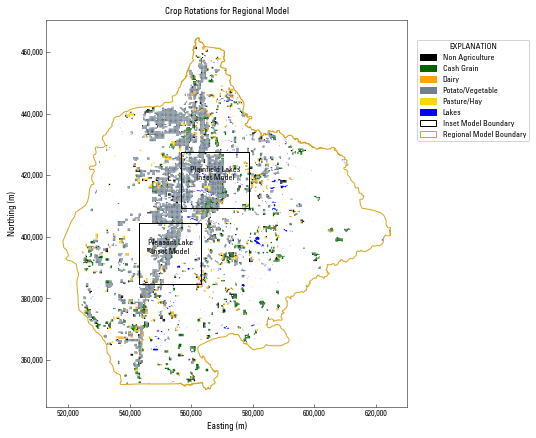

In [55]:
fig, ax = plt.subplots(figsize=doublecolumn_sizeT)
for ct, dat in croprot.groupby('rotation'):
    ccol = rotcolors[ct]
    dat.plot(color=ccol,
            ax=ax)
plsnt_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
ax.annotate(text='Pleasant Lake\nInset Model', xy=plsnt_bbox.geometry.values[0].centroid.coords[0],
           horizontalalignment = 'center')
pfl_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
ax.annotate(text='Plainfield Lakes\nInset Model', xy=pfl_bbox.geometry.values[0].centroid.coords[0],
           horizontalalignment = 'center')
alllakes.plot(ax=ax, facecolor="blue")
regional_bbox.plot(ax=ax, facecolor="none", edgecolor='GoldenRod')

# set up legend patches using the color and long-name dicts from above
leg_patches =[mpatches.Patch(color=c, label=rotnames[v]) for v,c in rotcolors.items()]
leg_patches.append(mpatches.Patch(color='blue', label='Lakes'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='black', label='Inset Model Boundary'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='GoldenRod', label='Regional Model Boundary'))

ax.legend(bbox_to_anchor=(1.35, .96), handles=leg_patches, title='EXPLANATION')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Crop Rotations for Regional Model')
plt.tight_layout()
plt.savefig('fig_x_regional_crop_rotations_map.pdf', bbox_inches='tight')

In [56]:
nonag_lu.wl_lev2_cd.unique()

array(['Nonirrigated Agriculture', 'Forested Wetland',
       'Coniferous Forest', 'Forage Grassland',
       'Broad-leaved Deciduous Forest', 'Emergent/Wet Meadow',
       'Idle Grassland'], dtype=object)

In [57]:

nonag_colors = {
    'Nonirrigated Agriculture': 'SlateGrey',
    'Forage Grassland': 'Gold',
    'Idle Grassland':'PaleGoldenRod',
    'Broad-leaved Deciduous Forest':'ForestGreen', 
    'Coniferous Forest': 'DarkGreen', 
    'Emergent/Wet Meadow': 'DeepSkyBlue',
    'Forested Wetland': 'SlateBlue'
}

/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/minico

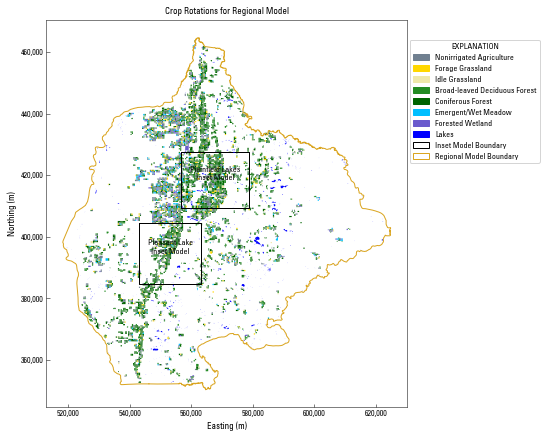

In [58]:
fig, ax = plt.subplots(figsize=doublecolumn_sizeT)
for ct, dat in nonag_lu.groupby('wl_lev2_cd'):
    ccol = nonag_colors[ct]
    dat.plot(color=ccol,
            ax=ax)
plsnt_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
ax.annotate(text='Pleasant Lake\nInset Model', xy=plsnt_bbox.geometry.values[0].centroid.coords[0],
           horizontalalignment = 'center')
pfl_bbox.plot(ax=ax, facecolor="none", edgecolor='black')
ax.annotate(text='Plainfield Lakes\nInset Model', xy=pfl_bbox.geometry.values[0].centroid.coords[0],
           horizontalalignment = 'center')
alllakes.plot(ax=ax, facecolor="blue")
regional_bbox.plot(ax=ax, facecolor="none", edgecolor='GoldenRod')

# set up legend patches using the color and long-name dicts from above
leg_patches =[mpatches.Patch(color=c, label=v) for v,c in nonag_colors.items()]
leg_patches.append(mpatches.Patch(color='blue', label='Lakes'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='black', label='Inset Model Boundary'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='GoldenRod', label='Regional Model Boundary'))

ax.legend(bbox_to_anchor=(1.38, .96), handles=leg_patches, title='EXPLANATION')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Crop Rotations for Regional Model')
plt.tight_layout()
plt.savefig('fig_x_regional_nonag_landuse_map.pdf', bbox_inches='tight')

In [59]:
# now for insets
pfl_nonag = gp.overlay(nonag_lu, pfl_bbox, how='intersection')

/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/minico

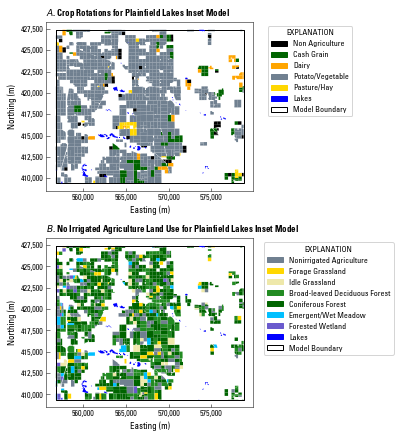

In [60]:
fig, ax = plt.subplots(2,1, figsize=doublecolumn_sizeT)
#pfl ag
for ct, dat in pfl_LU.groupby('rotation'):
    ccol = rotcolors[ct]
    dat.plot(color=ccol,
            ax=ax[0])
pfl_bbox.plot(ax=ax[0], facecolor="none", edgecolor='black')
pfl_lakes.plot(ax=ax[0], facecolor="blue")


# set up legend patches using the color and long-name dicts from above
leg_patches =[mpatches.Patch(color=c, label=rotnames[v]) for v,c in rotcolors.items()]
leg_patches.append(mpatches.Patch(color='blue', label='Lakes'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='black', label='Model Boundary'))
ax[0].legend(bbox_to_anchor=(1.5, 1.0), handles=leg_patches, title='EXPLANATION')
ax[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')
rf.title(ax[0],'Crop Rotations for Plainfield Lakes Inset Model',
                capitalize=False,
                 wrap=500,
                subplot_prefix='A')

# pfl no ag 
for ct, dat in pfl_nonag.groupby('wl_lev2_cd'):
    ccol = nonag_colors[ct]
    dat.plot(color=ccol,
            ax=ax[1])
pfl_bbox.plot(ax=ax[1], facecolor="none", edgecolor='black')
pfl_lakes.plot(ax=ax[1], facecolor="blue")


# set up legend patches using the color and long-name dicts from above
leg_patches =[mpatches.Patch(color=c, label=v) for v,c in nonag_colors.items()]
leg_patches.append(mpatches.Patch(color='blue', label='Lakes'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='black', label='Model Boundary'))
ax[1].legend(bbox_to_anchor=(1.7, 1.0), handles=leg_patches, title='EXPLANATION')
ax[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].set_xlabel('Easting (m)')
ax[1].set_ylabel('Northing (m)')
rf.title(ax[1],'No Irrigated Agriculture Land Use for Plainfield Lakes Inset Model',
                capitalize=False,
                 wrap=500,
                subplot_prefix='B')
plt.tight_layout()
plt.savefig('fig_x_pfl_inset_crop_rotations_map.pdf', bbox_inches='tight')





In [61]:
plsnt_nonag = gp.overlay(nonag_lu, plsnt_bbox, how='intersection')

/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/mnfienen/miniconda3/envs/dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mnfienen/minico

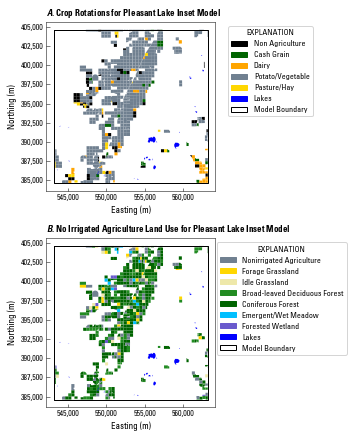

In [62]:
fig, ax = plt.subplots(2,1, figsize=doublecolumn_sizeT)
#pfl ag
for ct, dat in plsnt_LU.groupby('rotation'):
    ccol = rotcolors[ct]
    dat.plot(color=ccol,
            ax=ax[0])
plsnt_bbox.plot(ax=ax[0], facecolor="none", edgecolor='black')
plsnt_lakes.plot(ax=ax[0], facecolor="blue")


# set up legend patches using the color and long-name dicts from above
leg_patches =[mpatches.Patch(color=c, label=rotnames[v]) for v,c in rotcolors.items()]
leg_patches.append(mpatches.Patch(color='blue', label='Lakes'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='black', label='Model Boundary'))
ax[0].legend(bbox_to_anchor=(1.6, 1.0), handles=leg_patches, title='EXPLANATION')
ax[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')
rf.title(ax[0],'Crop Rotations for Pleasant Lake Inset Model',
                capitalize=False,
                 wrap=500,
                subplot_prefix='A')

# pfl no ag 
for ct, dat in plsnt_nonag.groupby('wl_lev2_cd'):
    ccol = nonag_colors[ct]
    dat.plot(color=ccol,
            ax=ax[1])
plsnt_bbox.plot(ax=ax[1], facecolor="none", edgecolor='black')
plsnt_lakes.plot(ax=ax[1], facecolor="blue")


# set up legend patches using the color and long-name dicts from above
leg_patches =[mpatches.Patch(color=c, label=v) for v,c in nonag_colors.items()]
leg_patches.append(mpatches.Patch(color='blue', label='Lakes'))
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='black', label='Model Boundary'))
ax[1].legend(bbox_to_anchor=(1.8, 1.0), handles=leg_patches, title='EXPLANATION')
ax[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].set_xlabel('Easting (m)')
ax[1].set_ylabel('Northing (m)')
rf.title(ax[1],'No Irrigated Agriculture Land Use for Pleasant Lake Inset Model',
                capitalize=False,
                 wrap=500,
                subplot_prefix='B')
plt.tight_layout()
plt.savefig('fig_x_plsnt_inset_crop_rotations_map.pdf', bbox_inches='tight')